# Discretization Classification 2.0(Template) - KFold
## Author: Ming

## Import Package

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 


#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## 1.Load Data

In [2]:
# Load Data
data_name = "Tsai_Original"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
 

## 2.Sampling

In [3]:
# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values

In [4]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 50000
特徵數量(不含Target) :: 37


In [5]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts)) #Major:1 ; minor2

{0: 36959, 1: 13041}

## Discretization_Python
Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            replace_coloumn.sort()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## Discretization Utility

In [7]:
class Discretization_utility:
    def __init__(self, continuous_data, discretize_coloumn):
        self.continuous_data_dataframe = continuous_data
        self.discretize_coloumn = discretize_coloumn

    # Deprecated
#     def SelectFeatures(self): ##Split Specific to Discretize
#         idx_IN_columns = self.discretize_coloumn
#         idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
#         selectData_list = self.training_data[:,idx_IN_columns]
#         disSelectData_list = self.training_data[:,idx_OUT_columns]
#         return selectData_list , disSelectData_list
    
    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.continuous_data_dataframe)[1]) if i not in idx_IN_columns]
        selectData_list = self.continuous_data_dataframe.iloc[:,idx_IN_columns]
        disSelectData_list = self.continuous_data_dataframe.iloc[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
    def PrintFirstFiveData(self,data,dataname): ##Split Specific to Discretize
        #print("["+str(dataname)+"]")
        #print(data.head(5))
        return 0
     

## Discretization with R
R package'Discretization'

In [8]:
class Discretization_rpy2:
    ## Input:X_train,y_train,X_test,y_test,discretize_coloumn,method
    ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe
    
    def discretize(X_train,y_train,X_test,y_test,discretize_coloumn,method):

        # Declare Discretizer_rpy2 (Select Continuous Feature, PrintFirstFive)
        discretize_train = Discretization_utility(X_train,discretize_coloumn)

        # Select Continuous Feature (Training Data Continuous Feature)
        X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns


        # Convert data to Dataframe for R Package "Discretization"
        ## R 'Discretization' require Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
        X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
        y_train_dataframe = pd.DataFrame(y_train)

        # Combine Select Continuous with Target
        X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
        X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1]) #Reshape for column index
        discretize_train.PrintFirstFiveData(X_y_train_continuousData_dataframe,"X_y_train_continuousData_dataframe")


        # Import R Package
        discretization = importr("discretization")
        disc_Topdown = robjects.r("disc.Topdown")

        print("-------------------------------"+method+" -----------------------------")

        # Discretize (R Package)
        ## Input: pandas.DataFrame  Output: rpy2.DataFrame
        if method == 'MDLP_R':
            X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
        elif method == 'CAIM_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
        elif method == 'ChiMerge_R':
            X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
        elif method == 'CACC_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
        elif method == 'Chi2_R':
            X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)

        # Transfer rpy2.DataFrame to pandas.DataFrame
        X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
        discretize_train.PrintFirstFiveData(X_y_train_disData_dataframe,"X_y_train_disData_dataframe")


        # Select the data(without target) in Combine_X_y_train_dis_dataframe 
        X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
        discretize_train.PrintFirstFiveData(X_train_disData_dataframe,"X_train_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_train_categorialData_dataframe,"X_train_categorialData_dataframe")            
        Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
        Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_train_dataframe,"Discretize_X_train_dataframe")


        # --------------------------------------Discretize Testing Data----------------------------------------------------

        # Enable Cutpoint for X_test (No Target)

        ## Declare Discretization_utility
        discretize_test = Discretization_utility(X_test,discretize_coloumn)

        ## Select Continuous Feature (Testing Data Continuous Feature)
        ## Return: List of data
        X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns


        ## Prepare X_test to enable cutpoint
        X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
        discretize_train.PrintFirstFiveData(X_test_continuousData_dataframe,"X_test_continuousData_dataframe")


        ## Get Cutpoint (Transfer to numpy array)
        cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
        #cutpoint_bins = np.array(cutpoint)
        #print("Original Cutbins")
        #print(cutpoint_bins)


        ## Declare dataframe for store data after discretize
        X_test_disData_dataframe = pd.DataFrame()

        # Iterate the cutbin to pd.cut the data
        for idx, val in enumerate(X_test_continuousData_dataframe):
            if cutpoint_bins[idx][0] == "All":
                #print(str(idx)+"_ALL")
                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
            else:        
                #print(str(idx)+"_NOTALL")
                cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                #print(type(cutpoint_bins[idx]))
                cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                #print(cutpoint_labels)

                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
        discretize_train.PrintFirstFiveData(X_test_disData_dataframe,"X_test_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_test_categorialData_dataframe,"X_test_categorialData_dataframe")

        Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
        Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_test_dataframe,"Discretize_X_test_dataframe")


        # Convert Target to Dataframe
        y_train_dataframe = pd.DataFrame(y_train)
        y_test_dataframe = pd.DataFrame(y_test)
        
        return Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe


## KFoldFuntion

In [9]:
class KFoldFuntion:
    # classifier, 
    # linear_svc,'linear_svc','','None','None','Dis-None', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, discretization_method, fs_method, method_order, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.discretization_method = discretization_method  # (None, MDLP, CAIM)
        self.fs_method = fs_method  # (None, C4.5, PCA, GA)
        self.method_order = method_order # (None-None, Dis-None, Dis-FS, FS-None, FS-Dis)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        # Main function
        ## Cross Validation, Discretization, (Feature Selection), Classifier
        
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            # Convert to Dataframe
            X_train_dataframe = pd.DataFrame(X_train)
            X_test_dataframe  = pd.DataFrame(X_test)
            y_train_dataframe = pd.DataFrame(y_train)
            y_test_dataframe  = pd.DataFrame(y_test)
            
            # Decide the process order (Dis-FS or FS-None)
            first_method, second_method = self.method_order.split('-')
            
            # Pre-Proecessing
            if first_method== 'Dis' and first_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif first_method== 'FS':
                print("Feature Selection")
                
            if second_method== 'Dis' and second_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif second_method== 'FS':
                print("Feature Selection")
            
          
            # Feature Preprocessing (Discretization, Feature Selection)


            # Discretization()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, discretization_method
            ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe

            # Feature Selection()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, method
            ## Output: X_train_dataframe,X_test_dataframe,y_train_dataframe,y_test_dataframe


            # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
            predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,
                                                    X_test_dataframe,y_test_dataframe)
            self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
        # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        # Convert Dataframe type from int to float (some classifier doesn't accept different dtype in same dataframe)
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{discretization_method}-{fs_method}-({method_order})-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,discretization_method=self.discretization_method,fs_method=self.fs_method,method_order=self.method_order,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [10]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    # Compare different Preprocessing (Dis-FS) figure
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [11]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [12]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

## Start Classify

## Run 10 Times

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarn

Mean Accuracy: 0.69948
Mean Accuracy[0.6934, 0.7025, 0.7036, 0.6982, 0.6997]
Mean Auc: 0.5898209581374457
Mean Auc[0.582143034857198, 0.5888034006322918, 0.5983137844637679, 0.5880225406520116, 0.5918220300819599]
Mean TypeII: 0.841235326100656
Mean TypeII[0.8245679939894816, 0.8465710964742348, 0.8615087040618955, 0.8336520076481836, 0.8398768283294842]
Mean TypeI: 0.10979257871109724
Mean TypeI[0.11869719269555737, 0.1064833535516916, 0.09939312204989885, 0.11347325660121868, 0.1109159686571197]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

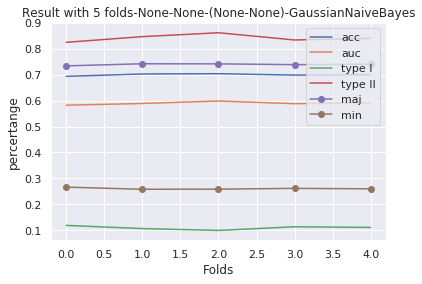

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.6245200000000001
Mean Accuracy[0.6265, 0.6214, 0.6334, 0.6242, 0.6171]
Mean Auc: 0.5249457630174699
Mean Auc[0.527334256194979, 0.5279387314090026, 0.5326724172416386, 0.521463373655914, 0.5153200365858148]
Mean TypeII: 0.6831998829311389
Mean TypeII[0.6844678450545317, 0.6685736079328757, 0.6777905638665133, 0.6890625, 0.696104897801774]
Mean TypeI: 0.26690859103392145
Mean TypeI[0.26086364255551014, 0.275548929249119, 0.25686460165020963, 0.26801075268817204, 0.2732550290265965]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Mean Accuracy: 0.73894
Mean Accuracy[0.7352, 0.7358, 0.7388, 0.7407, 0.7442]
Mean Auc: 0.6241672561904583
Mean Auc[0.6292269845191041, 0.6379516811676443, 0.6203380791250628, 0.6235117193224775, 0.6098078168180023]
Mean TypeII: 0.995771454950318
Mean TypeII[0.9965909090909091, 0.9992432841468029, 0.9988501341510158, 0.9869180454020777, 0.9972549019607844]
Mean TypeI: 0.0018108402121015728
Mean TypeI[0.0023097826086956523, 0.0001359249694168819, 0.0008117981328642944, 0.0037832725307390892, 0.0020134228187919465]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

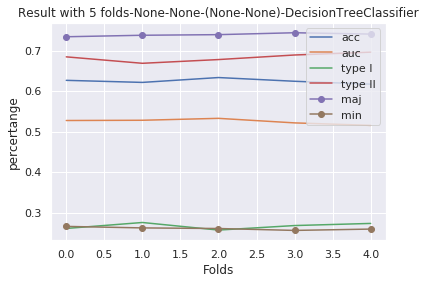

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

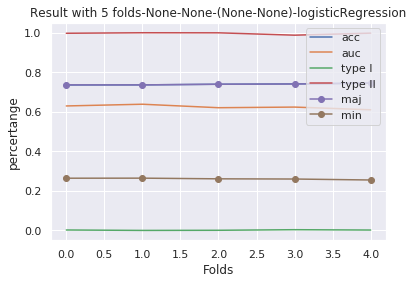

DiscretizationDiscretization

-------------------------------MDLP_R -----------------------------
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.68078
Mean Accuracy[0.677, 0.6753, 0.678, 0.6918, 0.6818]
Mean Auc: 0.5846151924112448
Mean Auc[0.59240361715314, 0.58476987138075, 0.5790660012958696, 0.5811417547212567, 0.5856947175052073]
Mean TypeII: 0.7623073624614883
Mean TypeII[0.7481231231231231, 0.7656903765690377, 0.7471624266144814, 0.7916984006092918, 0.7588624853915076]
Mean TypeI: 0.16283190573070186
Mean TypeI[0.1686205016357688, 0.16741283407950075, 0.1760913364674278, 0.1360184431787361, 0.16601641329207587]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

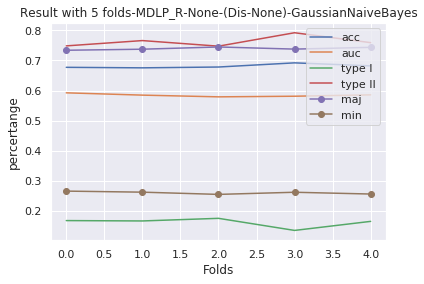

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.62788
Mean Accuracy[0.6291, 0.6232, 0.6304, 0.6276, 0.6291]
Mean Auc: 0.5301293001162236
Mean Auc[0.5318386116977417, 0.5281053341300906, 0.5315760379871517, 0.5310837245186764, 0.5280427922474575]
Mean TypeII: 0.6762540511728888
Mean TypeII[0.6717348927875244, 0.6644479248238058, 0.6801665404996216, 0.6761512542119057, 0.6887696435415868]
Mean TypeI: 0.264746089117054
Mean TypeI[0.2671149966375252, 0.27813591189900616, 0.25808643653166624, 0.2617000955109838, 0.2586930050060885]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.7216
Mean Accuracy[0.7193, 0.7256, 0.7249, 0.7147, 0.7235]
Mean Auc: 0.579796443449766
Mean Auc[0.5745556073541405, 0.5825284348438011, 0.5854141998372967, 0.5665886621256216, 0.58989531308797]
Mean TypeII: 0.9011832111174876
Mean TypeII[0.9082498072474943, 0.8963650425367363, 0.9038238702201622, 0.9094712818562191, 0.8880060537268256]
Mean TypeI: 0.05866164693519641
Mean TypeI[0.06089657034836619, 0.05745886161316428, 0.055458102820132235, 0.06267806267806268, 0.05681663721625663]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fon

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\An

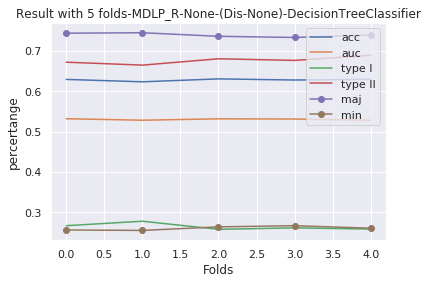

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
Mean Accuracy: 0.7380000000000001
Mean Accuracy[0.7482, 0.7329, 0.7347, 0.7337, 0.7405]
Mean Auc: 0.6253334666235599
Mean Auc[0.6228162740821118, 0.6213855483395136, 0.6202387579752219, 0.6303526866966033, 0.6318740660243488]
Mean TypeII: 0.9919207161260882
Mean TypeII[0.9904610492845787, 0.9913533834586467, 0.9954493742889647, 0.9932177844762623, 0.9891219891219891]
Mean TypeI: 0.00443658719170046
Mean TypeI[0.00347407803313736, 0.004632152588555858, 0.003802797772647019, 0.003675469643343316, 0.006598437920818745]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

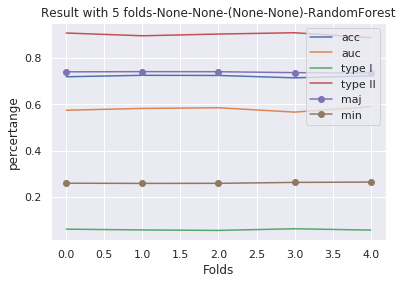

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.72956
Mean Accuracy[0.7403, 0.732, 0.7436, 0.6936, 0.7383]
Mean Auc: 0.5487592216507367
Mean Auc[0.5424630379372993, 0.5513279600763196, 0.5320671646244853, 0.563479010220849, 0.5544589353947293]
Mean TypeII: 0.9678264942428394
Mean TypeII[1.0, 0.999627004848937, 0.9988285825849278, 0.8425925925925926, 0.9980842911877394]
Mean TypeI: 0.02424417454985823
Mean TypeI[0.0, 0.0, 0.0008065600215082673, 0.11879049676025918, 0.0016238159675236806]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

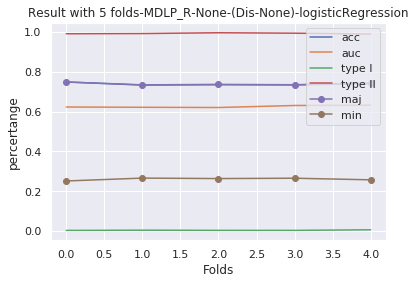

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

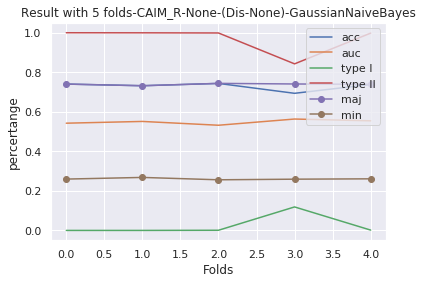

Discretization
-------------------------------ChiMerge_R -----------------------------
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.6328199999999999
Mean Accuracy[0.632, 0.6395, 0.6235, 0.6375, 0.6316]
Mean Auc: 0.5124499724523177
Mean Auc[0.5182228705287806, 0.5093680396130678, 0.5084052129996266, 0.5193541929943603, 0.5068995461257532]
Mean TypeII: 0.7390846096302556
Mean TypeII[0.7115613825983313, 0.7678437265214124, 0.7299382716049383, 0.7280334728033473, 0.7580461946232487]
Mean TypeI: 0.23573829216065473
Mean TypeI[0.2524388614192169, 0.21272826383210683, 0.25283477321814257, 0.23212589879256545, 0.22856366354124202]
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

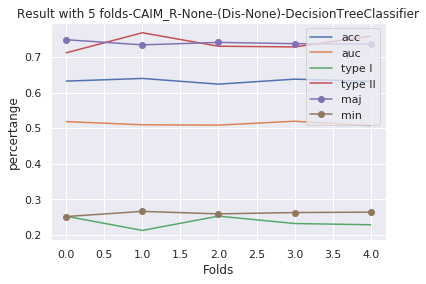

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.7397199999999999
Mean Accuracy[0.7441, 0.7358, 0.7424, 0.7323, 0.744]
Mean Auc: 0.6492491140275181
Mean Auc[0.6564726437357994, 0.6539268872522169, 0.638561103413695, 0.6536735380474675, 0.6436113976884121]
Mean TypeII: 0.9851712545463623
Mean TypeII[0.987923646279704, 0.9859689040576413, 0.9814456899884035, 0.9888059701492538, 0.9817120622568093]
Mean TypeI: 0.004491614721160853
Mean TypeI[0.0030943091618458227, 0.005704196658970528, 0.0049912316201268046, 0.0036885245901639345, 0.004979811574697173]
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Mean Accuracy: 0.73916
Mean Accuracy[0.7365, 0.7402, 0.7392, 0.7422, 0.7377]
Mean Auc: 0.606902137933697
Mean Auc[0.6098074769854146, 0.6076572474118578, 0.5992566993333864, 0.6108388371726938, 0.6069504287651324]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 2.7151778441487917e-05
Mean TypeI[0.00013575889220743959, 0.0, 0.0, 0.0, 0.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Mean Accuracy: 0.68972
Mean Accuracy[0.6962, 0.6929, 0.6805, 0.6975, 0.6815]
Mean Auc: 0.5839650689217779
Mean Auc[0.5953989722742413, 0.5876171244731517, 0.574345636221356, 0.5841738980157213, 0.5782897136244194]
Mean TypeII: 0.8031107274750576
Mean TypeII[0.8136241867585151, 0.8048498845265589, 0.786144578313253, 0.8198443579766537, 0.7910906298003072]
Mean TypeI: 0.13645089748658112
Mean TypeI[0.12346013266549344, 0.13239664955417454, 0.15073529411764705, 0.12355316285329744, 0.15210924824229313]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

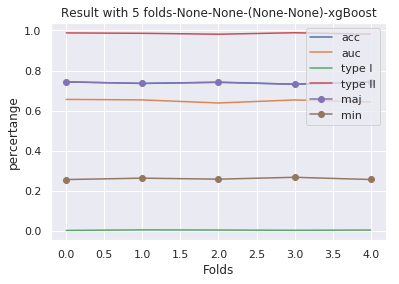

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is depr

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Mean Accuracy: 0.73918
Mean Accuracy[0.7364, 0.7396, 0.7449, 0.7396, 0.7354]
Mean Auc: 0.5942089562469741

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

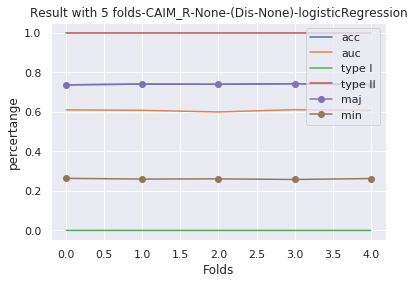


Mean Auc[0.5650483342249009, 0.6048113461089525, 0.6096306576869583, 0.6090795954802655, 0.5824748477337933]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

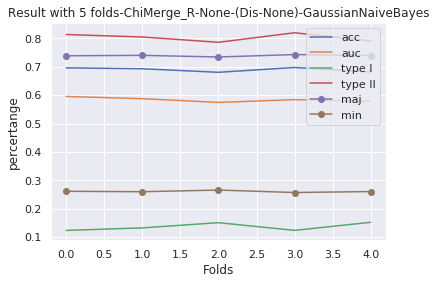

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Mean Accuracy: 0.62612
Mean Accuracy[0.6293, 0.6235, 0.6264, 0.6206, 0.6308]
Mean Auc: 0.5294538787496706
Mean Auc[0.5327835965881049, 0.5240281408547464, 0.5322172349566765, 0.5246907201949379, 0.5335497011538873]
Mean TypeII: 0.6733431031580591
Mean TypeII[0.6650998824911868, 0.6878306878306878, 0.6693002257336343, 0.6752300613496932, 0.6692546583850931]
Mean TypeI: 0.26818337302186457
Mean TypeI[0.26977306297838055, 0.264481914604297, 0.26654862435303733, 0.27502705627705626, 0.2650862068965517]
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\An

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

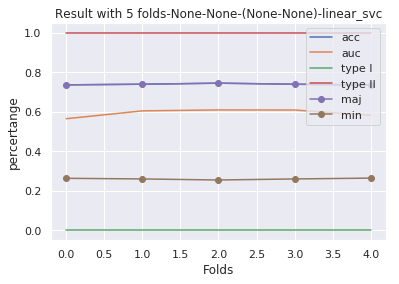

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

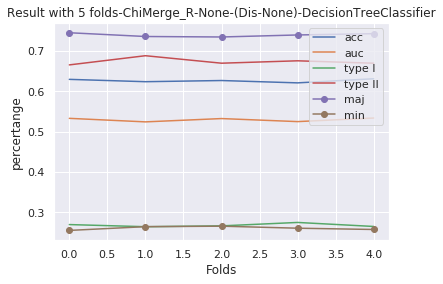

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
Discretization
-------------------------------CACC_R -----------------------------
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.7388600000000001
Mean Accuracy[0.7427, 0.7362, 0.7441, 0.7347, 0.7366]
Mean Auc: 0.5723632614529182
Mean Auc[0.5769505136953954, 0.5684356219617239, 0.572804537225581, 0.5725795426834526, 0.5710460916984383]
Mean TypeII: 0.9986135016186157
Mean TypeII[0.9984453944811504, 0.9992401215805471, 0.9976507439310884, 0.9984917043740573, 0.9992395437262357]
Mean TypeI: 0.0009192447154373326
Mean TypeI[0.0005385754678874377, 0.0010857763300760044, 0.00147730325006715, 0.0006804572672836146, 0.0008141112618724559]
Mean Accuracy: 0.71262
Mean Accuracy[0.7102, 0.7141, 0.7168, 0.7118, 0.7102]
Mean Auc: 0.5744481651205673
Mean Auc[0.5690402956088964, 0.5840952617962558, 0.5805163665282261, 0.57105107556543, 0.5675378261040281]
Mean TypeII: 0.8793068224882591
Mean TypeII[0.8781512605042017, 0.8666666666666667, 0.883765243902439, 0.8873943120676403, 0.880556629300348]
Mean TypeI: 0.07851365549342579
Mean TypeI[0.08114332159306421, 0.08078484438430311, 0.06954989154013015, 0.0774533657

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), 

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.7385999999999999
Mean Accuracy[0.7423, 0.7335, 0.7409, 0.7377, 0.7386]
Mean Auc: 0.6211681983235584
Mean Auc[0.6143356673531432, 0.6335561504119736, 0.6209100628081289, 0.6186829526903816, 0.6183561583541648]
Mean TypeII: 0.9923166940207746
Mean TypeII[0.9902912621359223, 0.995096190116937, 0.9918950212273253, 0.9911843618244538, 0.9931166347992352]
Mean TypeI: 0.003490555083060138
Mean TypeI[0.0036363636363636364, 0.003673969247516669, 0.0028343906060197058, 0.005006088485996482, 0.0023019634394041977]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

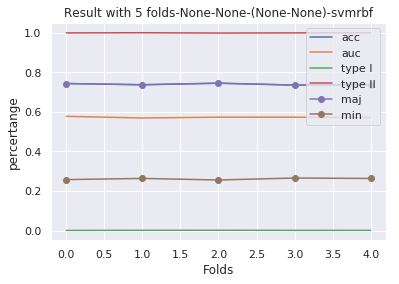

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.69988
Mean Accuracy[0.6751, 0.6647, 0.7401, 0.691, 0.7285]
Mean Auc: 0.5685632101572795
Mean Auc[0.5826108322157829, 0.5671959624813271, 0.5745805645161248, 0.5537986063227397, 0.5646300852504231]
Mean TypeII: 0.873342620113374
Mean TypeII[0.7625189681335357, 0.8057445200302343, 1.0, 0.8476744186046512, 0.9507751937984497]
Mean TypeI: 0.0982582256405106
Mean TypeI[0.1682509505703422, 0.16603209137884145, 0.0, 0.12169811320754717, 0.035309973045822104]Discretization

-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

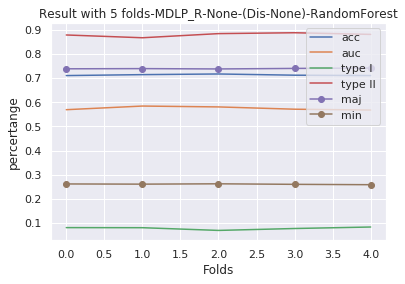

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

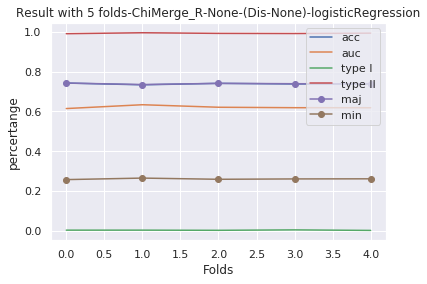

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Mean Accuracy: 0.60144
Mean Accuracy[0.6158, 0.6075, 0.587, 0.5942, 0.6027]
Mean Auc: 0.5139935918272599
Mean Auc[0.5164669730459204, 0.5168055419411756, 0.5063178385398011, 0.5246848027197542, 0.5056928028896486]
Mean TypeII: 0.6686658621062868
Mean TypeII[0.6891891891891891, 0.6745247148288973, 0.6644016610041525, 0.6186407766990292, 0.6965729688101656]
Mean TypeI: 0.3032324603720656
Mean TypeI[0.2775978407557355, 0.29185888738127547, 0.3224051149503469, 0.331986531986532, 0.2923139267864379]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

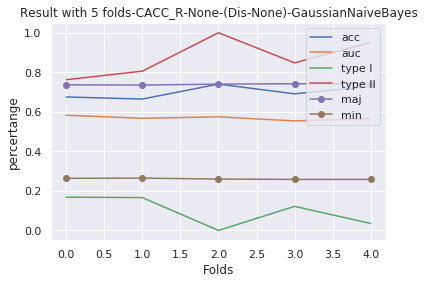

Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

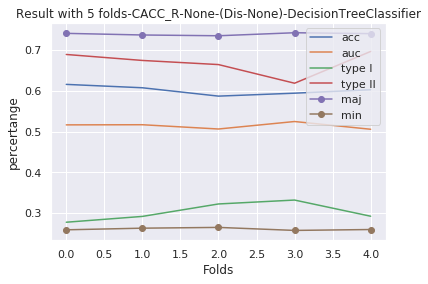

Discretization
-------------------------------CACC_R -----------------------------
Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.73746
Mean Accuracy[0.736, 0.7321, 0.7367, 0.7386, 0.7439]
Mean Auc: 0.6369676255791079
Mean Auc[0.6358083604433047, 0.6308544708046258, 0.6282828942918657, 0.6400280230657148, 0.6498643792900288]
Mean TypeII: 0.9655375431471219
Mean TypeII[0.9609942638623327, 0.972169988717563, 0.9657560600230858, 0.9668848671544089, 0.9618825359782186]
Mean TypeI: 0.01447598811797153
Mean TypeI[0.017197020988490182, 0.012804794987058984, 0.016619375760032428, 0.013913278400648385, 0.011845470453627676]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------Chi2_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), se

In [ ]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'None','None','None-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{clf_name}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,clf_name=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    

# ---------------MultiThread: First Version---------------
# thread_start_time = time.time()

# t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
# t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
# t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
# t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
# t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
# t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
# t6 = Thread(target=run10times,args=(mlp,"mlp"))
# t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
# t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
# t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
# t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
# t11 = Thread(target=run10times,args=(knn,"KNN"))

# #thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
# #thread_list = [t8]
# thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
# #thread_list = [t11,t10,t9,t7,t8]

# #程式開始
# for item in thread_list:
#     item.start()
# print("\n程式開始")


# #程式結束
# for item in thread_list:
#     item.join()
# print("\n程式結束")

# thread_end_time = time.time()  
# print("First Version time :", thread_end_time - thread_start_time)  


# ---------------MultiThread: Second Version---------------

t0=[svmlinear,"svmlinear"]
t1=[linear_svc,"linear_svc"]
t2=[svmrbf,"svmrbf"]
t3=[DecisionTreeClassifier,"DecisionTreeClassifier"]
t4=[RandomForest,"RandomForest"]
t5=[logisticRegression,"logisticRegression"]
t6=[mlp,"mlp"]
t7=[xgBoost,"xgBoost"]
t8=[GaussianNaiveBayes,"GaussianNaiveBayes"]
t9=[lboost,"LogitBoost"]
t10=[ada,"AdaBoost"]
t11=[knn,"KNN"]

from multiprocessing.dummy import Pool
if __name__ == '__main__':
    thread_start_time = time.time()
    pool = Pool()
    ##### Parameter: [1,2,3,4,5];  [(knn,"KNN"),(3,4)]
    #pool.starmap(run10times, [(knn,"KNN"),(lboost,"LogitBoost")])  # work in one thread
    pool.starmap_async(run10times, [t7]).get()
    #task = [(knn,"KNN"),(lboost,"LogitBoost"),(ada,"AdaBoost")]
#     with pool as p:
#         pool.starmap_async(run10times, (knn,"KNN")).get()
    pool.close()  
    #pool.join()    
    thread_end_time = time.time()  
    print("Second Version time :", thread_end_time - thread_start_time)  

#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))